<a href="https://colab.research.google.com/github/muGithub/Reinforcement-Learning-An-Introduction/blob/master/Chapter-04/car_rental_synchronous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

# This file is contributed by Tahsincan Köse which implements a synchronous policy evaluation, while the car_rental.py
# implements an asynchronous policy evaluation. This file also utilizes multi-processing for acceleration and contains
# an answer to Exercise 4.5

import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
import multiprocessing as mp
from functools import partial
import time
import itertools

############# PROBLEM SPECIFIC CONSTANTS #######################
MAX_CARS = 20
MAX_MOVE = 5
MOVE_COST = -2
ADDITIONAL_PARK_COST = -4

RENT_REWARD = 10
# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3
# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4
# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3
# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2
################################################################

poisson_cache = dict()


def poisson(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache.keys():
        poisson_cache[key] = math.exp(-lam) * math.pow(lam, n) / math.factorial(n)
    return poisson_cache[key]


class PolicyIteration:
    def __init__(self, truncate, parallel_processes, delta=1e-2, gamma=0.9, solve_4_5=False):
        self.TRUNCATE = truncate
        self.NR_PARALLEL_PROCESSES = parallel_processes
        self.actions = np.arange(-MAX_MOVE, MAX_MOVE + 1)
        self.inverse_actions = {el: ind[0] for ind, el in np.ndenumerate(self.actions)}
        self.values = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        self.policy = np.zeros(self.values.shape, dtype=np.int)
        self.delta = delta
        self.gamma = gamma
        self.solve_extension = solve_4_5

    def solve(self):
        iterations = 0
        total_start_time = time.time()
        while True:
            start_time = time.time()
            self.values = self.policy_evaluation(self.values, self.policy)
            elapsed_time = time.time() - start_time
            print(f'PE => Elapsed time {elapsed_time} seconds')
            start_time = time.time()

            policy_change, self.policy = self.policy_improvement(self.actions, self.values, self.policy)
            elapsed_time = time.time() - start_time
            print(f'PI => Elapsed time {elapsed_time} seconds')
            if policy_change == 0:
                break
            iterations += 1
        total_elapsed_time = time.time() - total_start_time
        print(f'Optimal policy is reached after {iterations} iterations in {total_elapsed_time} seconds')

    # out-place
    def policy_evaluation(self, values, policy):

        global MAX_CARS
        while True:
            new_values = np.copy(values)
            k = np.arange(MAX_CARS + 1)
            # cartesian product
            all_states = ((i, j) for i, j in itertools.product(k, k))

            results = []
            with mp.Pool(processes=self.NR_PARALLEL_PROCESSES) as p:
                cook = partial(self.expected_return_pe, policy, values)
                results = p.map(cook, all_states)

            for v, i, j in results:
                new_values[i, j] = v

            difference = np.abs(new_values - values).sum()
            print(f'Difference: {difference}')
            values = new_values
            if difference < self.delta:
                print(f'Values are converged!')
                return values

    def policy_improvement(self, actions, values, policy):
        new_policy = np.copy(policy)

        expected_action_returns = np.zeros((MAX_CARS + 1, MAX_CARS + 1, np.size(actions)))
        cooks = dict()
        with mp.Pool(processes=8) as p:
            for action in actions:
                k = np.arange(MAX_CARS + 1)
                all_states = ((i, j) for i, j in itertools.product(k, k))
                cooks[action] = partial(self.expected_return_pi, values, action)
                results = p.map(cooks[action], all_states)
                for v, i, j, a in results:
                    expected_action_returns[i, j, self.inverse_actions[a]] = v
        for i in range(expected_action_returns.shape[0]):
            for j in range(expected_action_returns.shape[1]):
                new_policy[i, j] = actions[np.argmax(expected_action_returns[i, j])]

        policy_change = (new_policy != policy).sum()
        print(f'Policy changed in {policy_change} states')
        return policy_change, new_policy

    # O(n^4) computation for all possible requests and returns
    def bellman(self, values, action, state):
        expected_return = 0
        if self.solve_extension:
            if action > 0:
                # Free shuttle to the second location
                expected_return += MOVE_COST * (action - 1)
            else:
                expected_return += MOVE_COST * abs(action)
        else:
            expected_return += MOVE_COST * abs(action)

        for req1 in range(0, TRUNCATE):
            for req2 in range(0, TRUNCATE):
                # moving cars
                num_of_cars_first_loc = int(min(state[0] - action, MAX_CARS))
                num_of_cars_second_loc = int(min(state[1] + action, MAX_CARS))

                # valid rental requests should be less than actual # of cars
                real_rental_first_loc = min(num_of_cars_first_loc, req1)
                real_rental_second_loc = min(num_of_cars_second_loc, req2)

                # get credits for renting
                reward = (real_rental_first_loc + real_rental_second_loc) * RENT_REWARD

                if self.solve_extension:
                    if num_of_cars_first_loc >= 10:
                        reward += ADDITIONAL_PARK_COST
                    if num_of_cars_second_loc >= 10:
                        reward += ADDITIONAL_PARK_COST

                num_of_cars_first_loc -= real_rental_first_loc
                num_of_cars_second_loc -= real_rental_second_loc

                # probability for current combination of rental requests
                prob = poisson(req1, RENTAL_REQUEST_FIRST_LOC) * \
                       poisson(req2, RENTAL_REQUEST_SECOND_LOC)
                for ret1 in range(0, TRUNCATE):
                    for ret2 in range(0, TRUNCATE):
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + ret1, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + ret2, MAX_CARS)
                        prob_ = poisson(ret1, RETURNS_FIRST_LOC) * \
                                poisson(ret2, RETURNS_SECOND_LOC) * prob
                        # Classic Bellman equation for state-value
                        # prob_ corresponds to p(s'|s,a) for each possible s' -> (num_of_cars_first_loc_,num_of_cars_second_loc_)
                        expected_return += prob_ * (
                                reward + self.gamma * values[num_of_cars_first_loc_, num_of_cars_second_loc_])
        return expected_return

    # Parallelization enforced different helper functions
    # Expected return calculator for Policy Evaluation
    def expected_return_pe(self, policy, values, state):

        action = policy[state[0], state[1]]
        expected_return = self.bellman(values, action, state)
        return expected_return, state[0], state[1]

    # Expected return calculator for Policy Improvement
    def expected_return_pi(self, values, action, state):

        if ((action >= 0 and state[0] >= action) or (action < 0 and state[1] >= abs(action))) == False:
            return -float('inf'), state[0], state[1], action
        expected_return = self.bellman(values, action, state)
        return expected_return, state[0], state[1], action

    def plot(self):
        print(self.policy)
        plt.figure()
        plt.xlim(0, MAX_CARS + 1)
        plt.ylim(0, MAX_CARS + 1)
        plt.table(cellText=self.policy, loc=(0, 0), cellLoc='center')
        plt.show()



Difference: 23784.04331721115
Difference: 20965.84490960801
Difference: 17966.357833173846
Difference: 15340.111364010107
Difference: 13075.05114812707
Difference: 11143.928423455853
Difference: 9514.955774426991
Difference: 8149.17582996943
Difference: 7004.797424795757
Difference: 6042.588732726692
Difference: 5228.915082786032
Difference: 4536.452230166284
Difference: 3943.5947625274503
Difference: 3433.4005257414765
Difference: 2992.5284789898506
Difference: 2610.3502646816073
Difference: 2278.2697716775992
Difference: 1989.2249907471682
Difference: 1737.330582772492
Difference: 1517.6221953959102
Difference: 1325.871834904829
Difference: 1158.452079512686
Difference: 1012.2337992280038
Difference: 884.5070738583496
Difference: 772.9184670845164
Difference: 675.4201239217051
Difference: 590.2276662391909
Difference: 515.7848345780687
Difference: 450.73345189534683
Difference: 393.8876912738288
Difference: 344.2118962688263
Difference: 300.80138100527034
Difference: 262.865759757732

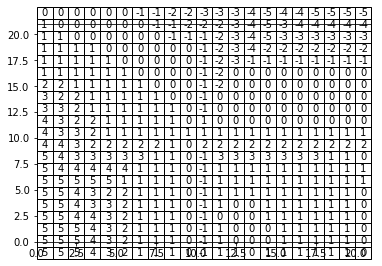

In [2]:
TRUNCATE = 9
solver = PolicyIteration(TRUNCATE, parallel_processes=4, delta=1e-1, gamma=0.9, solve_4_5=True)
solver.solve()
solver.plot()